In the previous blog, we talked about how to query USGS directly online, and plot the earthquakes on the map. In this blog, we will focus on how to use heatmap to represent the earthquakes. We will first try plot the heatmap on Basemap, which is not beautiful, then we will try to generate a nicer figure by plotting on google map.You can find all the script at Qingkai's Github. 

## Query USGS earthquake catalog

This part is the same as the previous blog. 

In [1]:
from bs4 import BeautifulSoup
import urllib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from functions import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# let's get the earthquake larger than M5 globally from 2010-01-01 to 2016-01-01. 
url = build_query(outFormat = 'text', starttime = '2010-01-01', endtime = '2016-01-01', minmagnitude = 5.0)
print url

# get the earthquake data from USGS and parse them into a numpy array
r = urllib.urlopen(url).read()
soup = BeautifulSoup(r, "lxml")
events_mat = parse_result(soup.text)

http://earthquake.usgs.gov/fdsnws/event/1/query?format=text&starttime=2010-01-01&endtime=2016-01-01&minmagnitude=5.0


In [3]:
# extract lat and lon for Basemap
lats = [float(item[2]) for item in events_mat]
lons = [float(item[3]) for item in events_mat]

## Plot heatmap on Basemap

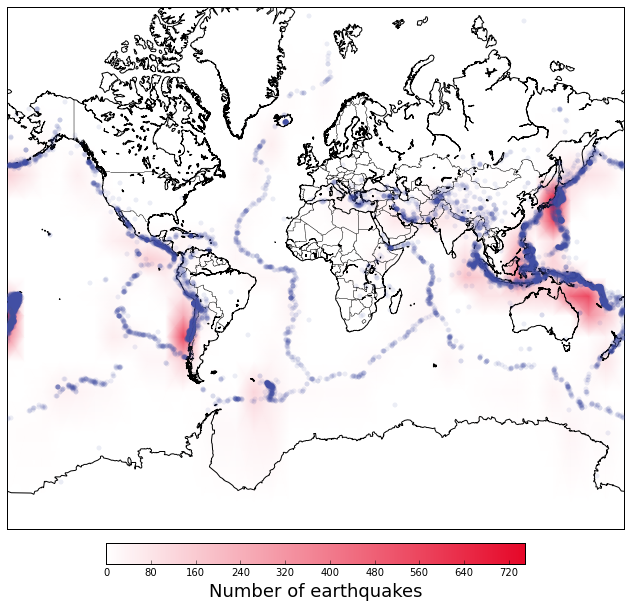

In [5]:
from matplotlib.colors import LinearSegmentedColormap

m = Basemap(projection='merc',llcrnrlat=-82,urcrnrlat=82,\
            llcrnrlon=-180,urcrnrlon=180, resolution = 'l')
m.drawcoastlines()
m.drawcountries()

# compute appropriate bins to aggregate data
# nx is number of bins in x-axis, i.e. longitude
# ny is number of bins in y-axis, i.e. latitude
nx = 36 # 10 degree for longitude bin
ny = 18 # 10 degree for latitude bin

# form the bins
lon_bins = np.linspace(-180, 180, nx)
lat_bins = np.linspace(-90, 90, ny)
    
# aggregate the number of earthquakes in each bin, we will only use the density
density, lat_edges, lon_edges = np.histogram2d(lats, lons, [lat_bins, lon_bins])

# get the mesh for the lat and lon
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = m(lon_bins_2d, lat_bins_2d) # will be plotted using pcolormesh

# define custom colormap, white -> red, #E6072A = RGB(0.9,0.03,0.16)
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }
custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)

# Here adding one row and column at the end of the matrix, so that 
# density has same dimension as xs, ys, otherwise, using shading='gouraud'
# will raise error
density = np.hstack((density,np.zeros((density.shape[0],1))))
density = np.vstack((density,np.zeros((density.shape[1]))))

# Plot heatmap with the custom color map
plt.pcolormesh(xs, ys, density, cmap="custom_map", shading='gouraud')

# Add color bar and 
cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Number of earthquakes',size=18)

# Plot blue scatter plot of epicenters above the heatmap:    
x,y = m(lons, lats)
m.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.1)

# make image bigger:
plt.gcf().set_size_inches(12,12)

plt.show()

## Plot heatmap on Google Map

In [ ]:
!pip install gmaps

In [6]:
import gmaps

<IPython.core.display.Javascript object>

In [7]:
# heatmap input data is (lat, lon, weight), weight is optional. 
data = [(float(item[2]), float(item[3])) for item in events_mat]

In [11]:
# plot the heatmap
gmaps.heatmap(data)

## Another package to plot on google map

Besides gmaps, another package, which is more flexible, is gmplot, you can use it to generate html directly.  

In [ ]:
!pip install gmplot

In [9]:
import gmplot

# declare the center of the map, and how much we want the map zoomed in
gmap = gmplot.GoogleMapPlotter(0, 0, 2)
# plot heatmap
gmap.heatmap(lats, lons)

In [10]:
# save it to html
gmap.draw("Earthquake_heatmap.html")

## Reference:

Basemap: http://www.uvm.edu/~jbagrow/dsv/heatmap_basemap.html

gmaps: https://github.com/pbugnion/gmaps

gmplot: https://github.com/vgm64/gmplot

